Based on https://www.kaggle.com/uciml/sms-spam-collection-dataset

https://www.kaggle.com/kredy10/simple-lstm-for-text-classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
df = pd.read_csv('spam.csv', delimiter=',', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
v1    5572 non-null object
v2    5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


Text(0.5, 1.0, 'Number of ham and spam messages')

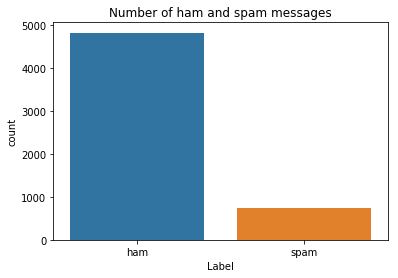

In [4]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [5]:
X = df['v1']
y = df['v2']
le = LabelEncoder()
y = le.fit_transform(y)
y = y.reshape(-1, 1)

In [6]:
y

array([[1079],
       [3101],
       [1000],
       ...,
       [3286],
       [3901],
       [3409]])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [8]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)

RNN

In [9]:
sequences_matrix

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int32)

In [10]:
sequences_matrix.shape

(3733, 150)

In [11]:
inputs = Input(name='inputs', shape=[max_len])
layer = Embedding(max_words, 50, input_length=max_len)(inputs)
layer = LSTM(64)(layer)
layer = Dense(256, name='FC1')(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(1, name='out_layer')(layer)
layer = Activation('sigmoid')(layer)
model = Model(inputs=inputs, outputs=layer)

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
__________

In [13]:
model.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [14]:
model.fit(sequences_matrix, y_train,
          batch_size=128, 
          epochs=10,
          validation_split=0.2,
          callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])

Train on 2986 samples, validate on 747 samples
Epoch 1/10
2986/2986 [==============================] - 27s 9ms/step - loss: -27063.1128 - acc: 0.0000e+00 - val_loss: -41505.0269 - val_acc: 0.0000e+00
Epoch 2/10
2986/2986 [==============================] - 28s 9ms/step - loss: -41198.6471 - acc: 0.0000e+00 - val_loss: -41505.0269 - val_acc: 0.0000e+00


In [15]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)

In [16]:
accr = model.evaluate(test_sequences_matrix, y_test)

1839/1839 [==============================] - 7s 4ms/step


In [17]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: -41192.668
  Accuracy: 0.001
